In [49]:
import pandas as pd
import numpy as np
from pulp import *
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn as sk
import re
import statsmodels.api as sm

In [2]:
file = 'ratings.csv'
data = pd.read_csv(file)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


In [5]:
data.head(10)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN
5,2575,Samyang Foods,Kimchi song Song Ramen,Pack,South Korea,4.75,NaN
6,2574,Acecook,Spice Deli Tantan Men With Cilantro,Cup,Japan,4,NaN
7,2573,Ikeda Shoku,Nabeyaki Kitsune Udon,Tray,Japan,3.75,NaN
8,2572,Ripe'n'Dry,Hokkaido Soy Sauce Ramen,Pack,Japan,0.25,NaN
9,2571,KOKA,The Original Spicy Stir-Fried Noodles,Pack,Singapore,2.5,NaN


In [7]:
df = data[data['Stars']!= 'Unrated']
df['Stars'] = df['Stars'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2577 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review #  2577 non-null   int64  
 1   Brand     2577 non-null   object 
 2   Variety   2577 non-null   object 
 3   Style     2575 non-null   object 
 4   Country   2577 non-null   object 
 5   Stars     2577 non-null   float64
 6   Top Ten   41 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 161.1+ KB


C:\Users\zacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Top 10 Countries based on Review Counts

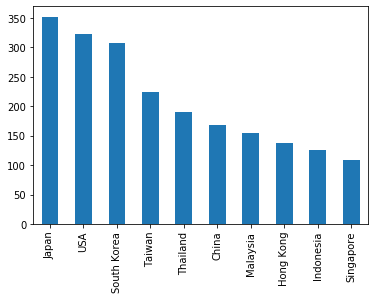

In [6]:
df['Country'].value_counts()[:10].plot(kind='bar')

Most Common Product Styles

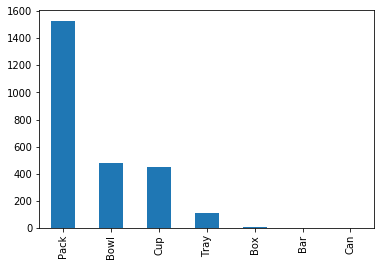

In [8]:
df['Style'].value_counts().plot(kind='bar')

In [20]:
df['Stars'].describe()

count    2577.000000
mean        3.654676
std         1.015331
min         0.000000
25%         3.250000
50%         3.750000
75%         4.250000
max         5.000000
Name: Stars, dtype: float64

Evaluating Most Common Varieties for Good Reviews (Review 4+ Stars) a.k.a. Short-version of Sentiment Analysis

In [39]:
word_lst = []
word_set = set()

good_reviews = df[df['Stars']>= 4]


for i in range(len(good_reviews)):
    s = good_reviews.iloc[i]['Variety']
    s_lst = [i for i in s.lower().split() if i.isalpha()]
    for x in s_lst:
        word_set.add(x)
        word_lst.append(x)

from collections import Counter
print('Most Common Words: ')
Counter(word_lst).most_common()       

Most Common Words: 


[('noodle', 263),
 ('noodles', 251),
 ('instant', 179),
 ('ramen', 174),
 ('flavour', 173),
 ('flavor', 137),
 ('spicy', 128),
 ('chicken', 96),
 ('cup', 92),
 ('sauce', 86),
 ('curry', 85),
 ('soup', 81),
 ('with', 73),
 ('beef', 73),
 ('mi', 68),
 ('goreng', 57),
 ('tom', 55),
 ('seafood', 52),
 ('penang', 49),
 ('hot', 48),
 ('rice', 47),
 ('bowl', 42),
 ('yum', 39),
 ('shrimp', 39),
 ('pork', 38),
 ('tonkotsu', 35),
 ('udon', 35),
 ('artificial', 31),
 ('demae', 30),
 ('yakisoba', 30),
 ('white', 29),
 ('ramyun', 28),
 ('creamy', 27),
 ('fried', 26),
 ('shoyu', 25),
 ('laksa', 25),
 ('sesame', 25),
 ('rasa', 23),
 ('black', 22),
 ('soy', 22),
 ('kimchi', 21),
 ('vermicelli', 21),
 ('style', 21),
 ('miso', 20),
 ('taste', 20),
 ('big', 19),
 ('king', 19),
 ('sabor', 19),
 ('chow', 19),
 ('original', 18),
 ('sour', 17),
 ('oil', 17),
 ('tomato', 17),
 ('raoh', 16),
 ('mein', 16),
 ('ayam', 16),
 ('yam', 15),
 ('pepper', 15),
 ('red', 15),
 ('prawn', 15),
 ('kari', 15),
 ('crab', 14),

Selecting some of the most common words included in the variety of products with good reviews (noodle/noodles, instant, flavor/flavour, spicy, chicken). Then, I create Indicator columns to indicate if that word is in the listed Variety within the overall dataset.

In [43]:
noodle_list = []
instant_list = []
flavor_list = []
spicy_list = []
chicken_list = []
stars_list = []

for i in range(len(df)):
    
    #Create word indicators for 5 selected words
    var = [i for i in df.iloc[i]['Variety'].lower().split() if i.isalpha()]
    
    if 'noodle' in var or 'noodles' in var:
        noodle_list.append(1)
    else:
        noodle_list.append(0)
    
    if 'instant' in var:
        instant_list.append(1)
    else:
        instant_list.append(0)
        
    if 'flavor' in var or 'flavour' in var:
        flavor_list.append(1)
    else:
        flavor_list.append(0)
        
    if 'spicy' in var:
        spicy_list.append(1)
    else:
        spicy_list.append(0)
        
    if 'chicken' in var:
        chicken_list.append(1)
    else:
        chicken_list.append(0)
        
df['Noodles'] = noodle_list
df['Instant'] = instant_list
df['Flavor'] = flavor_list
df['Spicy'] = spicy_list
df['Chicken'] = chicken_list
df.head()

C:\Users\zacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\zacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

,Review #,Brand,Variety,Style,Country,Stars,Top Ten,Noodles,Instant,Flavor,Spicy,Chicken
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN,0,0,0,0,0
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1.00,NaN,1,0,0,1,0
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN,1,0,0,0,1
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN,0,0,1,0,0
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN,0,0,0,0,0


Utilize Correlation Analysis to determine if there is any correlation between the Word Indicator fields produced and the Stars in the review. Results show little to no correlation unfortunately.

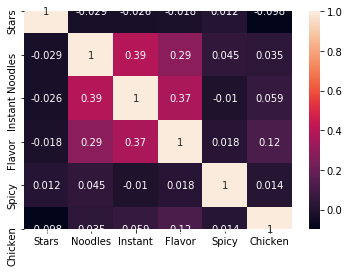

Spicy      0.011598
Flavor    -0.018110
Instant   -0.025904
Noodles   -0.029270
Chicken   -0.097935
Name: Stars, dtype: float64

In [47]:
col_lst = ['Stars', 'Noodles', 'Instant', 'Flavor', 'Spicy', 'Chicken']
Cor_matrix = df[col_lst].corr()
sn.heatmap(Cor_matrix, annot=True)
plt.show()

Cor_matrix['Stars'].sort_values(ascending=False)[1:]

Utilize Linear Regression to predict # of Stars based on word indicators. Results will show what words are significant (if any) on number of stars in the review, and if each word has a positive or negative impact based on its associated coefficient.

In [58]:
X = df[col_lst[1:]]
y = df[col_lst[0]]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2, hasconst = False)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Stars   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              5618.
Date:                Mon, 20 Dec 2021   Prob (F-statistic):                        0.00
Time:                        19:41:23   Log-Likelihood:                         -3681.6
No. Observations:                2577   AIC:                                      7375.
Df Residuals:                    2571   BIC:                                      7410.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7111      0.029    128.016      0.000       3.654       3.768
Noodles       -0.0466      0.044     -1.054      0.292      -0.133       0.040
Instant       -0.0345      0.060     -0.578      0.563      -0.152       0.083
Flavor         0.0100      0.049      0.206      0.837      -0.085       0.105
Spicy          0.0458      0.066      0.699      0.485      -0.083       0.174
Chicken       -0.2973      0.061     -4.914      0.000      -0.416      -0.179
==============================================================================
Omnibus:                      461.279   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              863.235
Skew:                          -1.099   Prob(JB):                    3.56e-188
Kurtosis:                       4.792   Cond. No.                         3.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Review** <br><br>
Overall, due to the limited amount of time to perform an extensive analysis, I selected the *Stars* variable as my target variable for my analysis. Due to the different features being string variables, I decided to further analyze the strings themselves, specifically the *Variety* field, to determine if any word that was found to be common in positive reviews would prove to have an influence on the number of stars given in a review. <br><br>

After finding the most common words found in good reviews (reviews of 4+ stars), I created indicator fields for each phrase to indicate whether or not each row in the data contained that specific word. Then, I utilized a correlation analysis to determine if the correlation relationship between each created indicator field and the *Stars* variable. The correlation between each indicator and the *Stars* variable was near 0, meaning the linear relationship between the variables was very low (essentially no relationship). I also performed a quick linear regression utilizing the created indicator variables as the X features and the *Stars* variable as the y variable attempting to be predicted. Based on the above Summary output of this regression, only the *Chicken* variable had any significance (p-value less than 0.05) in determining the Stars in a review. Interestingly, although these were phrases common in good reviews, 3 of the 5 variables had a negative impact on the number of expected Stars in the review. <br><br>

Lastly, if given more time to perform this analysis I think that I would have taken more time to perform a more in-depth sentiment analysis to determine how positive or negative phrases in the Variety variable were and how it affected the associated Stars variable, or chosen to assess geographic elements of the data, utilizing the Country variable to assess and visualize geographic factors in the data.